# Deep Learning

### Imports

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
from os import path
import sys
import tarfile
import random
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

### Retreive Data

In [2]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = 'data/' # Change me to store data elsewhere

def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified data/notMNIST_large.tar.gz
Found and verified data/notMNIST_small.tar.gz


### Extract from compressed tar.gz file

In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

data/notMNIST_large already present - Skipping extraction of data/notMNIST_large.tar.gz.
['data/notMNIST_large/A', 'data/notMNIST_large/B', 'data/notMNIST_large/C', 'data/notMNIST_large/D', 'data/notMNIST_large/E', 'data/notMNIST_large/F', 'data/notMNIST_large/G', 'data/notMNIST_large/H', 'data/notMNIST_large/I', 'data/notMNIST_large/J']
data/notMNIST_small already present - Skipping extraction of data/notMNIST_small.tar.gz.
['data/notMNIST_small/A', 'data/notMNIST_small/B', 'data/notMNIST_small/C', 'data/notMNIST_small/D', 'data/notMNIST_small/E', 'data/notMNIST_small/F', 'data/notMNIST_small/G', 'data/notMNIST_small/H', 'data/notMNIST_small/I', 'data/notMNIST_small/J']


## Problem 1

### Displaying some images

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded.

In [4]:
image_list = []

# collecting all image_files in train_folders and append to image_list
for folder in random.sample(train_folders, 1):
    for file in os.listdir(train_folders[0]):
        image_list.append(path.join(folder, file))

In [5]:
# display randomly images
images_to_display = 5
for imageName in random.sample(image_list, images_to_display):
    display(Image(filename=imageName))

### Load Data and convert entire dataset to 3D array

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road.

A few images might not be readable, we'll just skip them.

In [6]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

data/notMNIST_large/A.pickle already present - Skipping pickling.
data/notMNIST_large/B.pickle already present - Skipping pickling.
data/notMNIST_large/C.pickle already present - Skipping pickling.
data/notMNIST_large/D.pickle already present - Skipping pickling.
data/notMNIST_large/E.pickle already present - Skipping pickling.
data/notMNIST_large/F.pickle already present - Skipping pickling.
data/notMNIST_large/G.pickle already present - Skipping pickling.
data/notMNIST_large/H.pickle already present - Skipping pickling.
data/notMNIST_large/I.pickle already present - Skipping pickling.
data/notMNIST_large/J.pickle already present - Skipping pickling.
data/notMNIST_small/A.pickle already present - Skipping pickling.
data/notMNIST_small/B.pickle already present - Skipping pickling.
data/notMNIST_small/C.pickle already present - Skipping pickling.
data/notMNIST_small/D.pickle already present - Skipping pickling.
data/notMNIST_small/E.pickle already present - Skipping pickling.
data/notMN

## Problem 2

### Displaying sample labels and images of ndarray

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray.

In [7]:
def display_random_pickles(dataset, n):
    fig = plt.figure()
    
    for i in range(n):
        a = fig.add_subplot(n/(n/2), n/2, i+1)
        sample_set = random.sample(dataset, 1)[0]
        random_set = pickle.load(open(sample_set, 'rb'))
        plt.imshow(random_set[random.sample(range(random_set.shape[0]), 1)[0], :, :])
        plt.tight_layout()
        a.set_title(sample_set[sample_set.index('.pickle')-1])
        a.axes.get_xaxis().set_visible(False)
        a.axes.get_yaxis().set_visible(False)

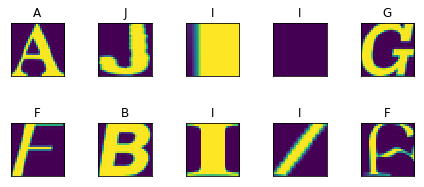

In [8]:
display_random_pickles(train_datasets, 10)

## Problem 3

### Balance check

Another check: we expect the data to be balanced across classes. Verify that.

In [21]:
len(pickle.load(open(train_datasets[1], 'rb')))

52911

In [34]:
letters = [chr(ord('A') + i) for i in range(0,10) ]
for i in range(0,10):
    train_set = pickle.load(open(train_datasets[i], 'rb'))
    print(letters[i] + ' in train set: ' + str(len(train_set)))
    test_set = pickle.load(open(test_datasets[i], 'rb'))
    print(letters[i] + ' in test set: ' + str(len(test_set)))

A in train set: 52909
A in test set: 1872
B in train set: 52911
B in test set: 1873
C in train set: 52912
C in test set: 1873
D in train set: 52911
D in test set: 1873
E in train set: 52912
E in test set: 1873
F in train set: 52912
F in test set: 1872
G in train set: 52912
G in test set: 1872
H in train set: 52912
H in test set: 1872
I in train set: 52912
I in test set: 1872
J in train set: 52911
J in test set: 1872


### Merge and prune data

Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune train_size as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [35]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


### Randomizing data

Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.


In [36]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

## Problem 4

### Check if data is still good

#### Train Data:

In [109]:
def display_random_data(data, labels, n):
    fig = plt.figure()
    
    for i in range(n):
        index = int(np.random.randint(len(data), size= 1))
        label = letters[int(labels[index])]
        train_set = data[index]
        a = fig.add_subplot(n/(n/2), n/2, i+1)
        a.set_title(label)
        a.axes.get_xaxis().set_visible(False)
        a.axes.get_yaxis().set_visible(False)
        plt.imshow(train_set)

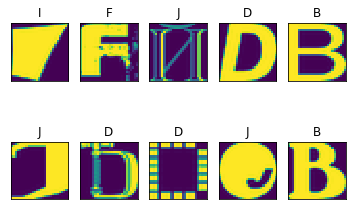

In [110]:
display_random_data(train_dataset, train_labels, 10)

#### Test Data

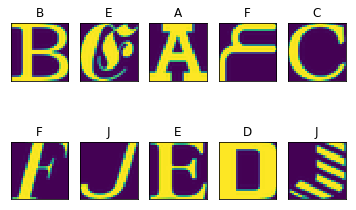

In [111]:
display_random_data(test_dataset, test_labels, 10)

#### Valid Data

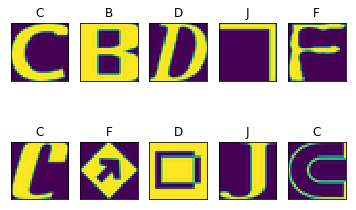

In [112]:
display_random_data(valid_dataset, valid_labels, 10)

### Save data for later use

In [113]:
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [114]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800506


## Problem 5

### Measure overlap

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it. Measure how much overlap there is between training, validation and test samples.

Optional questions:

- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.

In [119]:
len(pickle.load(open('notMNIST.pickle', 'rb')))

6

In [120]:
a = pickle.load(open('notMNIST.pickle', 'rb'))

In [126]:
a['train_dataset'][0].ndim

2

In [129]:
np.var(a['train_dataset'][0])

0.14271674